In [1]:
import os
import sys
import requests

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import confusion_matrix # , plot_confusion_matrix
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

In [2]:

# Define the ticker
ticker = 'AMZN'

def grab_price_data():
    """
    Grabs the daily price history for five tickers using the yfinance library 
    and stores the data in a CSV file in the specified format.
    
    Format: close,datetime,high,low,open,symbol,volume
    """

    # Store multiple result sets
    full_price_history = []

    # Fetch the data for all tickers
    
    price_history = yf.download(ticker, start='2020-01-01')

    # Add the required data to the full list in the specified format
    for index, row in price_history.iterrows():
        row_data = {
            'close': row['Close'],
            'datetime': index,
            'high': row['High'],
            'low': row['Low'],
            'open': row['Open'],
            'symbol': ticker,
            'volume': row['Volume']
        }
        full_price_history.append(row_data)

    # Convert the list to a DataFrame
    price_data = pd.DataFrame(full_price_history)

    # Reorder the columns
    price_data = price_data[['close', 'datetime', 'high', 'low', 'open', 'symbol', 'volume']]

    # Dump the data to a CSV file, without an index column
    price_data.to_csv(f'stock_data/{ticker}_price_data.csv', index=False)

# Example usage
grab_price_data()


[*********************100%***********************]  1 of 1 completed


In [3]:
csv_path = f'stock_data/{ticker}_price_data.csv'

if os.path.exists(csv_path):

    # Load the data
    price_data = pd.read_csv(csv_path)

else:

    # Grab the data and store it.
    grab_price_data()

    # Load the data
    price_data = pd.read_csv(csv_path)

# Display the head before moving on.
price_data.head()

,close,datetime,high,low,open,symbol,volume
0,94.900497,2020-01-02,94.900497,93.207497,93.750000,AMZN,80580000.0
1,93.748497,2020-01-03,94.309998,93.224998,93.224998,AMZN,75288000.0
2,95.143997,2020-01-06,95.184502,93.000000,93.000000,AMZN,81236000.0
3,95.343002,2020-01-07,95.694504,94.601997,95.224998,AMZN,80898000.0
4,94.598503,2020-01-08,95.550003,94.321999,94.902000,AMZN,70160000.0


In [4]:
# I Just need the Close
price_data = price_data[['symbol','datetime','close','high','low','open','volume']]


'''
    First, for average investors, the return of an asset is a complete and scale–free 
    summary of the investment opportunity. Second, return series are easier to 
    handle than prices series as they have more attractive statistical properties
'''


# sort the values by symbol and then date
price_data.sort_values(by = ['symbol','datetime'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['close'].diff()


In [5]:
# identify rows where the symbol changes
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 5
price_data[price_data.isna().any(axis = 1)]


,symbol,datetime,close,high,low,open,volume,change_in_price
0,AMZN,2020-01-02,94.900497,94.900497,93.207497,93.75,80580000.0,NaN


In [6]:
# define the number of days out you want to predict
days_out = 30

# Group by symbol, then apply the rolling function and grab the Min and Max.
price_data_smoothed = price_data.groupby(['symbol'])[['close','low','high','open','volume']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([price_data[['symbol','datetime']], price_data_smoothed], axis=1, sort=False)

smoothed_df

,symbol,datetime,close,low,high,open,volume
0,AMZN,2020-01-02,94.900497,93.207497,94.900497,93.750000,8.058000e+07
1,AMZN,2020-01-03,94.305297,93.216539,94.595406,93.478749,7.784580e+07
2,AMZN,2020-01-06,94.603702,93.139496,94.805003,93.308413,7.905201e+07
3,AMZN,2020-01-07,94.807406,93.542468,95.050093,93.836502,7.956065e+07
4,AMZN,2020-01-08,94.759876,93.719830,95.163834,94.078929,7.742177e+07
...,...,...,...,...,...,...,...
1170,AMZN,2024-08-27,177.338506,175.337550,179.456935,177.780528,4.004748e+07
1171,AMZN,2024-08-28,176.916667,174.923515,179.084875,177.516623,3.933764e+07
1172,AMZN,2024-08-29,176.607205,174.658127,178.775528,177.239422,3.850346e+07
1173,AMZN,2024-08-30,176.729321,174.525345,178.783558,176.951717,3.881792e+07


In [7]:
# define the number of days out you want to predict
days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('symbol')['close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)

,symbol,datetime,close,low,high,open,volume,Signal_Flag
0,AMZN,2020-01-02,94.900497,93.207497,94.900497,93.750000,8.058000e+07,NaN
1,AMZN,2020-01-03,94.305297,93.216539,94.595406,93.478749,7.784580e+07,NaN
2,AMZN,2020-01-06,94.603702,93.139496,94.805003,93.308413,7.905201e+07,NaN
3,AMZN,2020-01-07,94.807406,93.542468,95.050093,93.836502,7.956065e+07,NaN
4,AMZN,2020-01-08,94.759876,93.719830,95.163834,94.078929,7.742177e+07,NaN
5,AMZN,2020-01-09,94.817122,93.929192,95.306093,94.355863,7.466807e+07,NaN
6,AMZN,2020-01-10,94.703122,93.941439,95.313168,94.513710,7.162506e+07,NaN
7,AMZN,2020-01-13,94.681571,93.956818,95.248699,94.521791,6.912707e+07,NaN
8,AMZN,2020-01-14,94.508659,93.809674,95.121014,94.489227,6.908289e+07,NaN
9,AMZN,2020-01-15,94.322066,93.669805,94.964861,94.373012,6.760478e+07,NaN


In [8]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
0,AMZN,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000.0,NaN,NaN,NaN,NaN
1,AMZN,2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000.0,-1.152000,1.152000,0.000000,0.000000
2,AMZN,2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000.0,1.395500,0.000000,1.395500,58.293991
3,AMZN,2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000.0,0.199005,0.000000,0.199005,61.944271
4,AMZN,2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000.0,-0.744499,0.744499,0.000000,44.958446
5,AMZN,2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000.0,0.453995,0.000000,0.453995,53.860545
6,AMZN,2020-01-10,94.157997,95.347000,94.000000,95.268501,57074000.0,-0.894501,0.894501,0.000000,39.380723
7,AMZN,2020-01-13,94.565002,94.900002,94.040001,94.565498,55616000.0,0.407005,0.000000,0.407005,46.878463
8,AMZN,2020-01-14,93.472000,94.355499,92.927498,94.293999,68818000.0,-1.093002,1.093002,0.000000,33.889949
9,AMZN,2020-01-15,93.100998,93.943001,92.754501,93.612503,57932000.0,-0.371002,0.371002,0.000000,30.572389


In [9]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,AMZN,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMZN,2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000.0,-1.152000,1.152000,0.000000,0.000000,NaN,NaN,NaN
2,AMZN,2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000.0,1.395500,0.000000,1.395500,58.293991,NaN,NaN,NaN
3,AMZN,2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000.0,0.199005,0.000000,0.199005,61.944271,NaN,NaN,NaN
4,AMZN,2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000.0,-0.744499,0.744499,0.000000,44.958446,NaN,NaN,NaN
5,AMZN,2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000.0,0.453995,0.000000,0.453995,53.860545,NaN,NaN,NaN
6,AMZN,2020-01-10,94.157997,95.347000,94.000000,95.268501,57074000.0,-0.894501,0.894501,0.000000,39.380723,NaN,NaN,NaN
7,AMZN,2020-01-13,94.565002,94.900002,94.040001,94.565498,55616000.0,0.407005,0.000000,0.407005,46.878463,NaN,NaN,NaN
8,AMZN,2020-01-14,93.472000,94.355499,92.927498,94.293999,68818000.0,-1.093002,1.093002,0.000000,33.889949,NaN,NaN,NaN
9,AMZN,2020-01-15,93.100998,93.943001,92.754501,93.612503,57932000.0,-0.371002,0.371002,0.000000,30.572389,NaN,NaN,NaN


In [10]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,AMZN,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMZN,2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000.0,-1.152000,1.152000,0.000000,0.000000,NaN,NaN,NaN,NaN
2,AMZN,2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000.0,1.395500,0.000000,1.395500,58.293991,NaN,NaN,NaN,NaN
3,AMZN,2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000.0,0.199005,0.000000,0.199005,61.944271,NaN,NaN,NaN,NaN
4,AMZN,2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000.0,-0.744499,0.744499,0.000000,44.958446,NaN,NaN,NaN,NaN
5,AMZN,2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000.0,0.453995,0.000000,0.453995,53.860545,NaN,NaN,NaN,NaN
6,AMZN,2020-01-10,94.157997,95.347000,94.000000,95.268501,57074000.0,-0.894501,0.894501,0.000000,39.380723,NaN,NaN,NaN,NaN
7,AMZN,2020-01-13,94.565002,94.900002,94.040001,94.565498,55616000.0,0.407005,0.000000,0.407005,46.878463,NaN,NaN,NaN,NaN
8,AMZN,2020-01-14,93.472000,94.355499,92.927498,94.293999,68818000.0,-1.093002,1.093002,0.000000,33.889949,NaN,NaN,NaN,NaN
9,AMZN,2020-01-15,93.100998,93.943001,92.754501,93.612503,57932000.0,-0.371002,0.371002,0.000000,30.572389,NaN,NaN,NaN,NaN


In [11]:
# Calculate the MACD
ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,AMZN,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,AMZN,2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000.0,-1.152000,1.152000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.025846,-0.014359
2,AMZN,2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000.0,1.395500,0.000000,1.395500,58.293991,NaN,NaN,NaN,NaN,0.010341,-0.004236
3,AMZN,2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000.0,0.199005,0.000000,0.199005,61.944271,NaN,NaN,NaN,NaN,0.033732,0.008626
4,AMZN,2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000.0,-0.744499,0.744499,0.000000,44.958446,NaN,NaN,NaN,NaN,0.016106,0.010851
5,AMZN,2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000.0,0.453995,0.000000,0.453995,53.860545,NaN,NaN,NaN,NaN,0.024621,0.014583
6,AMZN,2020-01-10,94.157997,95.347000,94.000000,95.268501,57074000.0,-0.894501,0.894501,0.000000,39.380723,NaN,NaN,NaN,NaN,-0.010865,0.008143
7,AMZN,2020-01-13,94.565002,94.900002,94.040001,94.565498,55616000.0,0.407005,0.000000,0.407005,46.878463,NaN,NaN,NaN,NaN,-0.015127,0.002551
8,AMZN,2020-01-14,93.472000,94.355499,92.927498,94.293999,68818000.0,-1.093002,1.093002,0.000000,33.889949,NaN,NaN,NaN,NaN,-0.072077,-0.014688
9,AMZN,2020-01-15,93.100998,93.943001,92.754501,93.612503,57932000.0,-0.371002,0.371002,0.000000,30.572389,NaN,NaN,NaN,NaN,-0.130536,-0.040645


In [12]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,AMZN,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,AMZN,2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000.0,-1.152000,1.152000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.025846,-0.014359,NaN
2,AMZN,2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000.0,1.395500,0.000000,1.395500,58.293991,NaN,NaN,NaN,NaN,0.010341,-0.004236,NaN
3,AMZN,2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000.0,0.199005,0.000000,0.199005,61.944271,NaN,NaN,NaN,NaN,0.033732,0.008626,NaN
4,AMZN,2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000.0,-0.744499,0.744499,0.000000,44.958446,NaN,NaN,NaN,NaN,0.016106,0.010851,NaN
5,AMZN,2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000.0,0.453995,0.000000,0.453995,53.860545,NaN,NaN,NaN,NaN,0.024621,0.014583,NaN
6,AMZN,2020-01-10,94.157997,95.347000,94.000000,95.268501,57074000.0,-0.894501,0.894501,0.000000,39.380723,NaN,NaN,NaN,NaN,-0.010865,0.008143,NaN
7,AMZN,2020-01-13,94.565002,94.900002,94.040001,94.565498,55616000.0,0.407005,0.000000,0.407005,46.878463,NaN,NaN,NaN,NaN,-0.015127,0.002551,NaN
8,AMZN,2020-01-14,93.472000,94.355499,92.927498,94.293999,68818000.0,-1.093002,1.093002,0.000000,33.889949,NaN,NaN,NaN,NaN,-0.072077,-0.014688,NaN
9,AMZN,2020-01-15,93.100998,93.943001,92.754501,93.612503,57932000.0,-0.371002,0.371002,0.000000,30.572389,NaN,NaN,NaN,NaN,-0.130536,-0.040645,-0.018962


In [13]:
# Define the OBV function
def obv(df):
    # Grab the volume and close column
    volume = df['volume']
    change = df['close'].diff()

    # Initialize the previous OBV
    prev_obv = 0
    obv_values = []

    # Calculate the On Balance Volume
    for i, j in zip(change, volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # Update previous OBV and append the current OBV
        prev_obv = current_obv
        obv_values.append(current_obv)

    # Return a pandas series
    return pd.Series(obv_values, index=df.index)

# Apply the OBV function directly to the DataFrame
price_data['On Balance Volume'] = obv(price_data)

# Display the first 30 rows of the DataFrame
price_data.head(30)


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,AMZN,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.0
1,AMZN,2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000.0,-1.152000,1.152000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.025846,-0.014359,NaN,-75288000.0
2,AMZN,2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000.0,1.395500,0.000000,1.395500,58.293991,NaN,NaN,NaN,NaN,0.010341,-0.004236,NaN,5948000.0
3,AMZN,2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000.0,0.199005,0.000000,0.199005,61.944271,NaN,NaN,NaN,NaN,0.033732,0.008626,NaN,86846000.0
4,AMZN,2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000.0,-0.744499,0.744499,0.000000,44.958446,NaN,NaN,NaN,NaN,0.016106,0.010851,NaN,16686000.0
5,AMZN,2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000.0,0.453995,0.000000,0.453995,53.860545,NaN,NaN,NaN,NaN,0.024621,0.014583,NaN,80032000.0
6,AMZN,2020-01-10,94.157997,95.347000,94.000000,95.268501,57074000.0,-0.894501,0.894501,0.000000,39.380723,NaN,NaN,NaN,NaN,-0.010865,0.008143,NaN,22958000.0
7,AMZN,2020-01-13,94.565002,94.900002,94.040001,94.565498,55616000.0,0.407005,0.000000,0.407005,46.878463,NaN,NaN,NaN,NaN,-0.015127,0.002551,NaN,78574000.0
8,AMZN,2020-01-14,93.472000,94.355499,92.927498,94.293999,68818000.0,-1.093002,1.093002,0.000000,33.889949,NaN,NaN,NaN,NaN,-0.072077,-0.014688,NaN,9756000.0
9,AMZN,2020-01-15,93.100998,93.943001,92.754501,93.612503,57932000.0,-0.371002,0.371002,0.000000,30.572389,NaN,NaN,NaN,NaN,-0.130536,-0.040645,-0.018962,-48176000.0


In [14]:
#  Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.head(50)

# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
0,AMZN,2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.0,NaN
1,AMZN,2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000.0,-1.152000,1.152000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.025846,-0.014359,NaN,-75288000.0,-1.0
2,AMZN,2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000.0,1.395500,0.000000,1.395500,58.293991,NaN,NaN,NaN,NaN,0.010341,-0.004236,NaN,5948000.0,1.0
3,AMZN,2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000.0,0.199005,0.000000,0.199005,61.944271,NaN,NaN,NaN,NaN,0.033732,0.008626,NaN,86846000.0,1.0
4,AMZN,2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000.0,-0.744499,0.744499,0.000000,44.958446,NaN,NaN,NaN,NaN,0.016106,0.010851,NaN,16686000.0,-1.0
5,AMZN,2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000.0,0.453995,0.000000,0.453995,53.860545,NaN,NaN,NaN,NaN,0.024621,0.014583,NaN,80032000.0,1.0
6,AMZN,2020-01-10,94.157997,95.347000,94.000000,95.268501,57074000.0,-0.894501,0.894501,0.000000,39.380723,NaN,NaN,NaN,NaN,-0.010865,0.008143,NaN,22958000.0,-1.0
7,AMZN,2020-01-13,94.565002,94.900002,94.040001,94.565498,55616000.0,0.407005,0.000000,0.407005,46.878463,NaN,NaN,NaN,NaN,-0.015127,0.002551,NaN,78574000.0,1.0
8,AMZN,2020-01-14,93.472000,94.355499,92.927498,94.293999,68818000.0,-1.093002,1.093002,0.000000,33.889949,NaN,NaN,NaN,NaN,-0.072077,-0.014688,NaN,9756000.0,-1.0
9,AMZN,2020-01-15,93.100998,93.943001,92.754501,93.612503,57932000.0,-0.371002,0.371002,0.000000,30.572389,NaN,NaN,NaN,NaN,-0.130536,-0.040645,-0.018962,-48176000.0,-1.0


In [15]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Before NaN Drop we have 1175 rows and 20 columns
After NaN Drop we have 1162 rows and 20 columns


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
13,AMZN,2020-01-22,94.373001,95.125000,94.167000,94.804497,64326000.0,-0.226997,0.226997,0.000000,51.600606,92.754501,95.890999,51.602138,-48.397862,-0.077856,-0.085148,-0.002384,-65102000.0,-1.0
14,AMZN,2020-01-23,94.228996,94.499001,93.638000,94.255501,49692000.0,-0.144005,0.144005,0.000000,49.787205,92.754501,95.890999,47.010876,-52.989124,-0.063433,-0.080647,-0.008664,-114794000.0,-1.0
15,AMZN,2020-01-24,93.082001,94.749496,92.372002,94.568497,75324000.0,-1.146996,1.146996,0.000000,37.632701,92.372002,95.890999,20.176176,-79.823824,-0.121257,-0.089004,-0.011428,-190118000.0,-1.0
16,AMZN,2020-01-27,91.417000,92.050003,90.766998,91.000000,70570000.0,-1.665001,1.665001,0.000000,26.710643,90.766998,95.890999,12.685430,-87.314570,-0.266889,-0.125401,-0.033289,-260688000.0,-1.0
17,AMZN,2020-01-28,92.662498,92.905502,91.500999,92.025002,56160000.0,1.245499,0.000000,1.245499,41.392175,90.766998,95.890999,36.992584,-63.007416,-0.296615,-0.160272,-0.008660,-204528000.0,1.0


In [16]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [17]:
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  71.1340206185567


In [18]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.709459,0.719178,0.714286,146.00000
Up Day,0.713287,0.703448,0.708333,145.00000
accuracy,0.711340,0.711340,0.711340,0.71134
macro avg,0.711373,0.711313,0.711310,291.00000
weighted avg,0.711367,0.711340,0.711320,291.00000


In [19]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

r_percent               0.198994
k_percent               0.196197
RSI                     0.175904
MACD                    0.160172
Price_Rate_Of_Change    0.143129
On Balance Volume       0.125605
dtype: float64

In [20]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [21]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1, error_score="raise")

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=20, min_samples_split=40, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=20, min_samples_split=40, n_estimators=400; total time=   1.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=20, min_samples_split=40, n_estimators=400; total time=   1.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=7, min_samples_split=40, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=16, min_samples_split=2, n_estimators=400; total time=   2.2s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=16, min_samples_split=2, n_estimators=400; total time=   2.2s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=16, min_samples_split=2, n_esti

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', None, 'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=0, verbose=2)

In [22]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)

'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)

Correct Prediction (%):  72.5085910652921


,precision,recall,f1-score,support
Down Day,0.709459,0.719178,0.714286,146.00000
Up Day,0.713287,0.703448,0.708333,145.00000
accuracy,0.711340,0.711340,0.711340,0.71134
macro avg,0.711373,0.711313,0.711310,291.00000
weighted avg,0.711367,0.711340,0.711320,291.00000


r_percent               0.198994
k_percent               0.196197
RSI                     0.175904
MACD                    0.160172
Price_Rate_Of_Change    0.143129
On Balance Volume       0.125605
dtype: float64

In [23]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=100, max_features=None, min_samples_leaf=20,
                       min_samples_split=40, n_estimators=1400)

In [24]:
# Predict for the future

cur_data = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']].tail(1)
preds = rf_random.predict(cur_data)
cert = rf_random.predict_proba(cur_data)[0]  # Assuming binary classification

# Determine the predicted value and its associated probability
if cert[0] > cert[1]:
    val = "Down"
    prob = cert[0]
else:
    val = "Up"
    prob = cert[1]

# Output the result
print(f"Prediction: {val}, Confidence: {prob * 100:.2f}%")



Prediction: Up, Confidence: 68.86%


Day 1: Actual: -1, Predicted: -1.0 (Down), Certainty: 64.13%, Percent Change: -0.010870683674738046%, Total Money: 1006.7491957550465, Money spend on day: 6.858648173741127, Date: 2024-05-22
Day 2: Actual: -1, Predicted: -1.0 (Down), Certainty: 81.29%, Percent Change: -1.1325284708593362%, Total Money: 1009.7628289434743, Money spend on day: 14.580482576872853, Date: 2024-05-23
Day 3: Actual: -1, Predicted: -1.0 (Down), Certainty: 91.01%, Percent Change: -0.16515445187891012%, Total Money: 1027.0203424130686, Money spend on day: 18.956489220881124, Date: 2024-05-24
Day 4: Actual: 1, Predicted: -1.0 (Down), Certainty: 58.75%, Percent Change: 0.7780770040974074%, Total Money: 1035.0113515247872, Money spend on day: 0, Date: 2024-05-28
Day 5: Actual: -1, Predicted: -1.0 (Down), Certainty: 64.60%, Percent Change: -0.07154079593106559%, Total Money: 1041.3354365135776, Money spend on day: 7.06959799432252, Date: 2024-05-29
Day 6: Actual: -1, Predicted: -1.0 (Down), Certainty: 80.68%, Percen

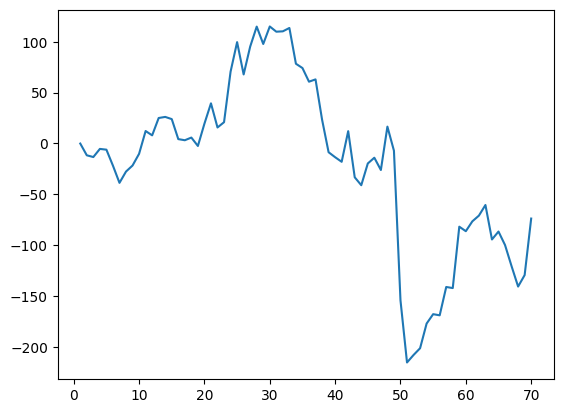

In [25]:
principle = 1000
time_span = 70
total_money_spent = 1000

# init for arrays for numpy
x_points = []
y_points_total = []
y_points_spent = []
y_points_profit = []

# Define your prediction and certainty check logic here
for i in range(time_span):
    # Get Date
    date = price_data['datetime'].iloc[-time_span -1 + i]

    # Get the last i + 1 row(s) for prediction
    cur_data = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']].iloc[-time_span -1 + i:-time_span + i]
    
    # Make the prediction
    predicted = rf_random.predict(cur_data)[0]
    
    # Get the prediction probabilities (certainty)
    cert = rf_random.predict_proba(cur_data)[0]

    # calculate the actual percentage change of the stock on the current day
    percentage_change = price_data['change_in_price'].iloc[-time_span - 1 + i] / price_data['open'].iloc[-time_span - 1 + i]

     # Get the actual value for comparison
    actual = -1 if percentage_change < 0 else 1

    # Determine the certainty and direction
    if cert[0] > cert[1]:
        val = "Down"
        prob = cert[0]
    else:
        val = "Up"
        prob = cert[1]

    # calculate sum of money to be bought
    b = 5 + 45 * (prob - 0.6) if prob >= 0.6 else 0

    # calculate sum after day
    principle += b
    principle = principle + principle * percentage_change
    total_money_spent += b

    x_points.append(i + 1)
    y_points_total.append(principle)
    y_points_spent.append(total_money_spent)
    y_points_profit.append(principle - total_money_spent)
    
    # Print actual, predicted, and certainty
    print(f"Day {i+1}: Actual: {actual}, Predicted: {predicted} ({val}), Certainty: {prob * 100:.2f}%, Percent Change: {percentage_change * 100}%, Total Money: {principle}, Money spend on day: {b}, Date: {date}")

print(f"Profit: {principle - total_money_spent}")

x_points = np.array(x_points)
y_points_total = np.array(y_points_total)
y_points_spent = np.array(y_points_spent)
y_points_profit = np.array(y_points_profit)

# plt.plot(x_points, y_points_spent)
# plt.plot(x_points, y_points_total)
plt.plot(x_points, y_points_profit)

plt.show()


In [26]:
import joblib

# Assuming 'model' is your trained Random Forest model
joblib.dump(rf_random, f'models/{ticker}_model.pkl')
price_data.to_csv(f'stock_data/{ticker}_price_data.csv', index=False)